In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable

from sklearn.preprocessing import normalize

from tqdm import tnrange, tqdm_notebook

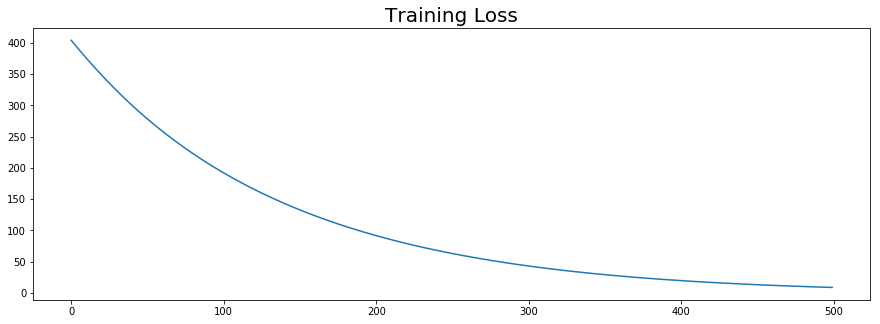

In [167]:
loss = np.load('loss.npy')

plt.figure(figsize=(15,5))

plt.plot(loss)

plt.title('Training Loss', fontsize=20)
plt.show()

In [114]:
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors=200):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, 
                                               n_factors,
                                               sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, 
                                               n_factors,
                                               sparse=True)
        
    def forward(self, user, item):
        return (self.user_factors(user) * self.item_factors(item)).sum(1)
    
    def user(self, user):
        return self.user_factors(user)
    
    def item(self, item):
        return self.item_factors(item)

In [115]:
original = pd.read_excel('online_retail.xlsx')
dat = pd.read_csv('rankings.csv')
cids = dat['CustomerID']
dat.drop('CustomerID', inplace=True, axis=1)

In [170]:
# instantiate model
n_users = dat.shape[0]
n_items = dat.shape[1]

model = MatrixFactorization(n_users, n_items, n_factors=400)

In [171]:
model.load_state_dict(torch.load('cpu_model.bin'))

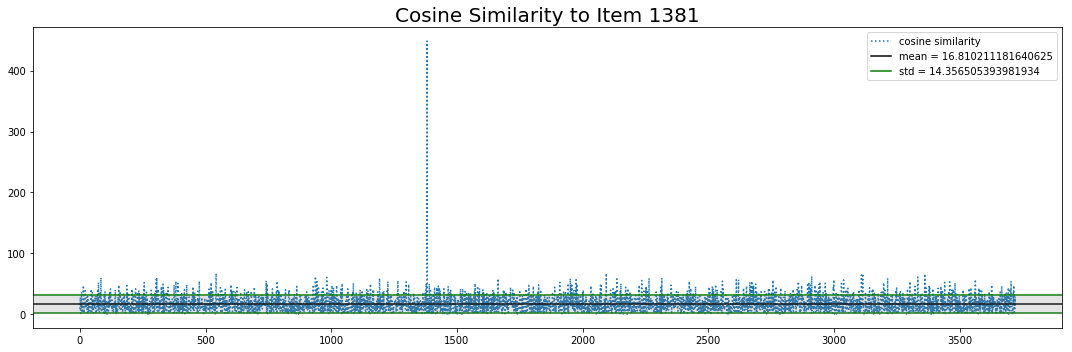

top 5 most similar items 

index: 1381
	 CHRISTMAS GINGHAM STAR
index: 542
	 BLUE POLKADOT WRAP
index: 2094
	 MINT DINER WALL CLOCK
index: 3114
	 FOLK ART GREETING CARD,pack/12
index: 3361
	 JUMBO  BAG BAROQUE BLACK WHITE


In [178]:
cosine_similarities = []

#itemnumber = 1000
itemnumber = np.random.randint(0, 3650)

item1 = Variable(torch.LongTensor([np.long(itemnumber)]))
item1 = model.item(item1).data.numpy()[0]

for i in range(dat.shape[1]):
    item2 = Variable(torch.LongTensor([np.long(i)]))
    item2 = model.item(item2).data.numpy()[0]
    
    cosine_similarities.append(np.dot(item1, item2))
    
cosine_similarities = np.array(cosine_similarities)
cosine_similarities = np.abs(cosine_similarities)

plt.figure(figsize=(15,5))

plt.plot(cosine_similarities, label='cosine similarity', ls='dotted')

plt.axhline(cosine_similarities.mean(), c='k', label='mean = {}'.format(cosine_similarities.mean()))
plt.axhline(cosine_similarities.mean()+cosine_similarities.std(), c='g', label='std = {}'.format(cosine_similarities.std()))
plt.axhline(cosine_similarities.mean()-cosine_similarities.std(), c='g')
plt.axhspan(cosine_similarities.mean()+cosine_similarities.std(), cosine_similarities.mean()-cosine_similarities.std(), color='grey', alpha=.2, zorder=10)

plt.title('Cosine Similarity to Item {}'.format(itemnumber), fontsize=20)
plt.tight_layout()
plt.legend()

#plt.savefig('/home/gram/Pictures/item_CS_mapping.png', transparent=True, dpi=300)
plt.show()

stock_codes = np.array(list(dat.columns))

num_of_items = 5

similars = pd.Series(cosine_similarities).nlargest(n=num_of_items)
idx = list(similars.index)
similars = stock_codes[list(similars.index)]

print('top {} most similar items'.format(num_of_items), '\n')

j = 0
for i in similars:
    try:
        val = int(i)
    except ValueError:
        val = i
        
    print('index:', idx[j])
    j += 1
    print('\t',original[original['StockCode'] == val].iloc[0]['Description'])

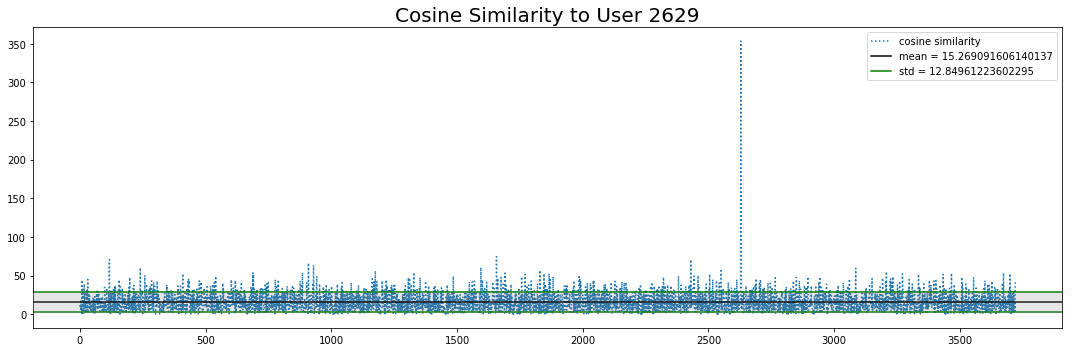

The top 10 items of the top 5 most similar customers. 

user index: 2629
['ROSE 1 WICK MORRIS BOXED CANDLE', 'EGG FRYING PAN IVORY ', "POPPY'S PLAYHOUSE KITCHEN", 'VINTAGE DONKEY TAIL GAME ', 'BOTANICAL ROSE GREETING CARD', 'HAPPY STENCIL CRAFT', 'MONSTERS STENCIL CRAFT', 'MAGIC DRAWING SLATE SPACEBOY ', 'EGG FRYING PAN PINK ', 'MAGIC DRAWING SLATE DOLLY GIRL '] 

user index: 1657
['TOILET METAL SIGN', 'BATHROOM METAL SIGN', 'WHITE WOOD GARDEN PLANT LADDER', 'WHITE BROCANTE SOAP DISH', 'WHITE SOAP RACK WITH 2 BOTTLES', 'CHRISTMAS HANGING TREE WITH BELL', 'LETTER "Z" BLING KEY RING', 'LIPSTICK PEN BABY PINK', 'ENAMEL FIRE BUCKET CREAM', 'ENAMEL FLOWER JUG CREAM'] 

user index: 117
[" 50'S CHRISTMAS GIFT BAG LARGE", 'FAWN BLUE HOT WATER BOTTLE', '12 PENCIL SMALL TUBE WOODLAND', 'SCOTTIE DOG HOT WATER BOTTLE', 'ROBOT BIRTHDAY CARD', 'RED RETROSPOT CHARLOTTE BAG', 'WOODLAND CHARLOTTE BAG', 'ROUND SNACK BOXES SET OF4 WOODLAND ', 'CARD CAT AND TREE ', 'CHICK GREY HOT WATER BOTTLE'] 

user in

In [184]:
cosine_similarities = []

#usernumber = 1000
usernumber = np.random.randint(0, 4372)

user1 = Variable(torch.LongTensor([np.long(usernumber)]))
user1 = model.user(user1).data.numpy()[0]

for i in range(dat.shape[1]):
    user2 = Variable(torch.LongTensor([np.long(i)]))
    user2 = model.user(user2).data.numpy()[0]
    
    cosine_similarities.append(np.dot(user1, user2))
    
cosine_similarities = np.array(cosine_similarities)
cosine_similarities = np.abs(cosine_similarities)

plt.figure(figsize=(15,5))

plt.plot(cosine_similarities, label='cosine similarity', ls='dotted')

plt.axhline(cosine_similarities.mean(), c='k', label='mean = {}'.format(cosine_similarities.mean()))
plt.axhline(cosine_similarities.mean()+cosine_similarities.std(), c='g', label='std = {}'.format(cosine_similarities.std()))
plt.axhline(cosine_similarities.mean()-cosine_similarities.std(), c='g')
plt.axhspan(cosine_similarities.mean()+cosine_similarities.std(), cosine_similarities.mean()-cosine_similarities.std(), color='grey', alpha=.2, zorder=10)

plt.title('Cosine Similarity to User {}'.format(usernumber), fontsize=20)
plt.tight_layout()
plt.legend()

#plt.savefig('/home/gram/Pictures/user_CS_mapping.png', transparent=True, dpi=300)
plt.show()


num_of_users = 5
num_of_items = 10

print('The top {} items of the top {} most similar customers.'.format(num_of_items, num_of_users), '\n')

idx = list(pd.Series(cosine_similarities).nlargest(n=num_of_users).index)

for j in idx:
    userproducts = []

    stock_codes = list(dat.iloc[j,0:3676].sort_values(ascending=False).index)[:num_of_items]
    
    for i in stock_codes:
        try:
            val = int(i)
        except ValueError:
            val = i

        userproducts.append(original[original['StockCode'] == val].iloc[0]['Description'])

    print('user index:', j)
    print(userproducts, '\n')